In [1]:
import keras 
from keras import layers
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.utils import plot_model
from tqdm.keras import TqdmCallback


Using TensorFlow backend.
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [2]:
%matplotlib inline  


In [3]:
os.listdir("seg_train")

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

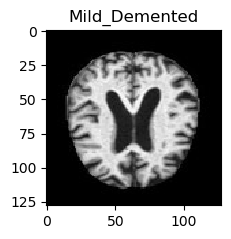

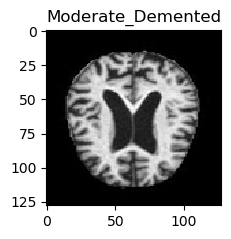

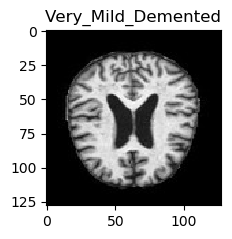

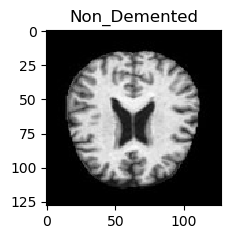

In [4]:
im='seg_train/Mild_Demented/mild.jpg'

plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
plt.imshow(cv2.imread(im))
plt.title("Mild_Demented")
#--------------------
s='seg_train/Moderate_Demented/moderate.jpg'
plt.figure(figsize=(5,5))

plt.subplot(2 , 2, 2)     # means the fig has 1 row and 2 columns and this plot is the secnd plot 

plt.imshow(cv2.imread(s))
plt.title('Moderate_Demented')
plt.show()
#--------------------
s='seg_train/Very_Mild_Demented/verymild.jpg'
plt.figure(figsize=(5,5))

plt.subplot(2 , 2, 3)     # means the fig has 1 row and 2 columns and this plot is the secnd plot 
plt.imshow(cv2.imread(s))
plt.title('Very_Mild_Demented')
plt.show()
#--------------------
s='seg_train/Non_Demented/non.jpg'
plt.figure(figsize=(5,5))

plt.subplot(2 , 2, 4)     # means the fig has 1 row and 2 columns and this plot is the secnd plot 
plt.imshow(cv2.imread(s))
plt.title('Non_Demented')
plt.show()

In [5]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2) 

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_data = train_datagen.flow_from_directory("seg_train", 
                                               target_size=(150, 150), 
                                               color_mode='rgb',
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

test_data = val_datagen.flow_from_directory("seg_train", 
                                           target_size=(150, 150), 
                                           color_mode='rgb',
                                           batch_size=32, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
#trian_data=trian_gene.flow_from_directory(directory="seg_train",target_size=(150,150),batch_size=32,shuffle=True,class_mode='categorical')

In [8]:
#test_gen=ImageDataGenerator(rescale=1./255)
#test_data=test_gen.flow_from_directory('seg_test',target_size=(150,150),batch_size=1,shuffle=True)

In [9]:
#trian_data.class_indices

In [10]:
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
)

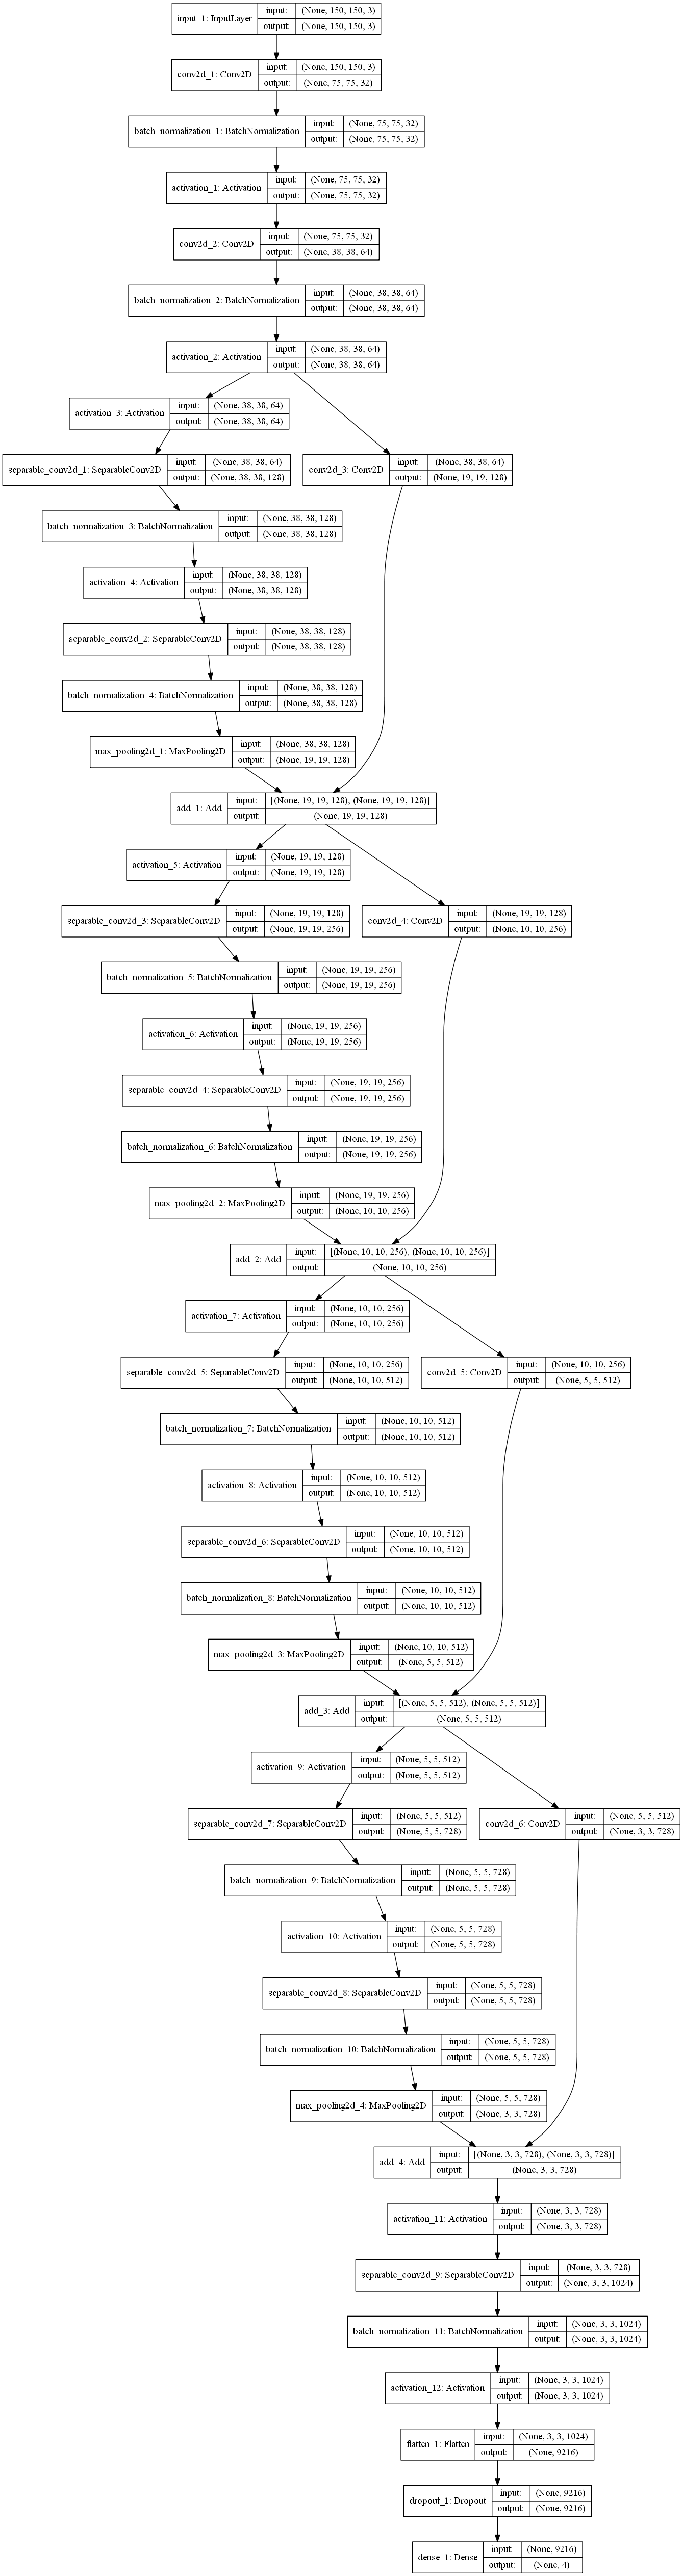

In [11]:
def make_model(input_shape, num_classes):
    inputs=keras.Input(shape=input_shape)
    x=inputs
    x=keras.layers.Conv2D(32,3,strides=2,padding='same')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    
    x=keras.layers.Conv2D(64,3,strides=2,padding='same')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation("relu")(x)
    skip_shortcut=x
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x=keras.layers.MaxPooling2D(3,strides=2,padding='same')(x)
        
        residual=keras.layers.Conv2D(size,1,strides=2,padding='same')(skip_shortcut)
        x=layers.add([x,residual])
        skip_shortcut=x
        
    x=layers.Activation("relu")(x)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) 
    x=layers.Flatten()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(150,150,3), num_classes=6)
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True)        

        
    
    

In [12]:
inputs=keras.layers.Input(shape=(150,150,3))
x=inputs
x=layers.Conv2D(32,3,strides=2,activation="relu",padding="valid")(x)
x=keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same")(x)  
x=keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=keras.layers.BatchNormalization()(x)
skip_short=x
for i in [4,8,16,32]:
    x=keras.layers.Activation("relu")(x)
    x=keras.layers.Conv2D(filters=i,kernel_size=(3,3),activation="relu",padding="same")(x) 
    
    
    x=layers.Conv2D(i,3,activation="relu",padding="valid")(x)
    x=keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same")(x)  
    x=keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x=keras.layers.BatchNormalization()(x)


    x=layers.Conv2D(i,3,strides=2,activation="relu",padding="valid")(x)
    x=keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same")(x)  
    x=keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x=keras.layers.BatchNormalization()(x)



    x=layers.Conv2D(i,3,activation="relu",padding="valid")(x)
    x=keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same")(x)  
    x=keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x=keras.layers.BatchNormalization()(x)

    x=keras.layers.Conv2D(filters=i,kernel_size=(3,3),padding="same")(x)
    res=keras.layers.Conv2D(filters=i,kernel_size=(3,3),padding="same")(skip_short)
    x=keras.layers.add([x,res])
    skip_short=x
    
    
x=keras.layers.Activation("relu")(x)    
x=keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same")(x)  
x=keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=keras.layers.BatchNormalization()(x)

x=keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same")(x)  
x=keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x=keras.layers.BatchNormalization()(x)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(500,activation="relu")(x)
x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(250,activation="relu")(x)
x=keras.layers.Dense(4,activation="softmax")(x)




In [13]:
model=keras.Model(inputs=inputs,outputs=x)

In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 74, 74, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 74, 74, 32)   9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 37, 37, 32)   0           conv2d_8[0][0]                   
____________________________________________________________________________________________

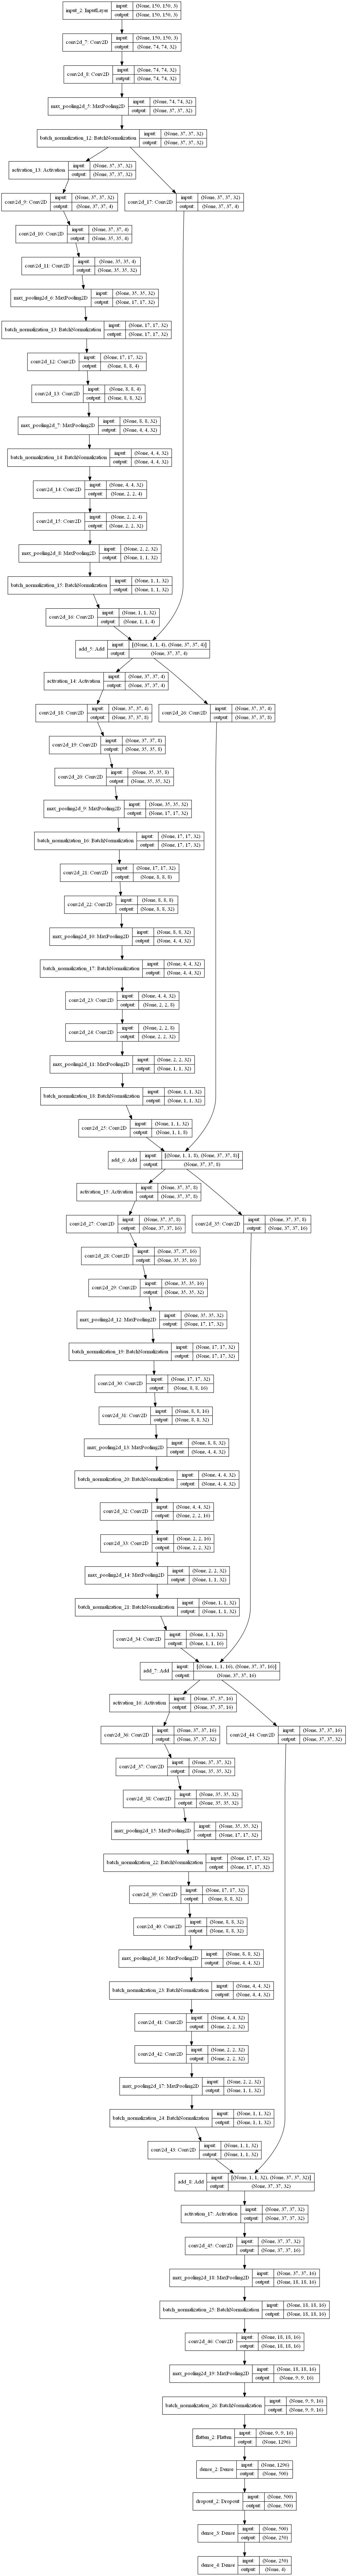

In [15]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True)        


In [16]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [17]:
h=model.fit(train_data,validation_data=test_data,epochs=20,shuffle=True,callbacks=[reduce_lr,es])


Epoch 1/20
161/161 [==============================] - 28s 173ms/step - loss: 1.1416 - accuracy: 0.4812 - val_loss: 0.4625 - val_accuracy: 0.3503
Epoch 2/20
161/161 [==============================] - 22s 139ms/step - loss: 0.9774 - accuracy: 0.5202 - val_loss: 0.3546 - val_accuracy: 0.3503
Epoch 3/20
161/161 [==============================] - 23s 142ms/step - loss: 0.9426 - accuracy: 0.5333 - val_loss: 0.2563 - val_accuracy: 0.3503
Epoch 4/20
161/161 [==============================] - 23s 142ms/step - loss: 0.9316 - accuracy: 0.5401 - val_loss: 0.2472 - val_accuracy: 0.3503
Epoch 5/20
161/161 [==============================] - 23s 144ms/step - loss: 0.9179 - accuracy: 0.5452 - val_loss: 0.0923 - val_accuracy: 0.3503
Epoch 6/20
161/161 [==============================] - 23s 142ms/step - loss: 0.9090 - accuracy: 0.5491 - val_loss: 0.1051 - val_accuracy: 0.3503
Epoch 7/20
161/161 [==============================] - 23s 145ms/step - loss: 0.9080 - accuracy: 0.5436 - val_loss: 0.2684 - val_a

In [18]:
model.evaluate(test_data)


40/40 [==============================] - 1s 18ms/step


[0.024634668603539467, 0.35027363896369934]

In [19]:
h.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

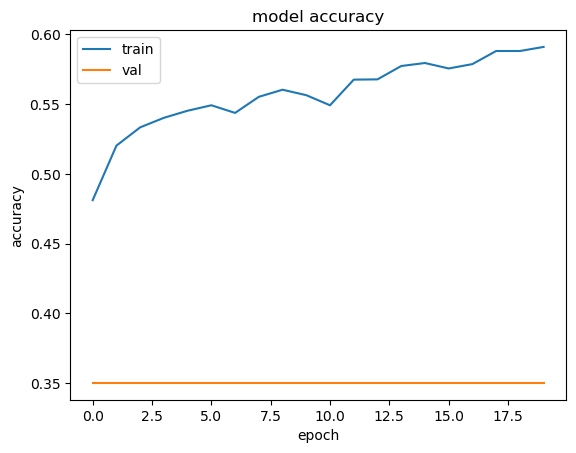

In [20]:

import keras
from matplotlib import pyplot as plt
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

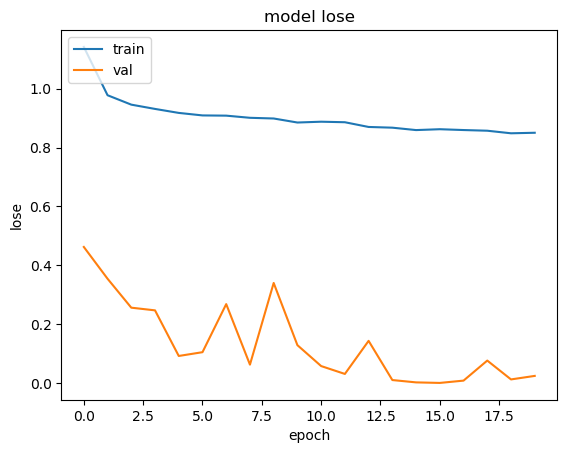

In [21]:

import keras
from matplotlib import pyplot as plt
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model lose')
plt.ylabel('lose')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
import glob, random
images =glob.glob('seg_train/glacier/*.jpg')
for i in range (10):
    random_image = random.choice(images)
    print(random_image)

IndexError: Cannot choose from an empty sequence